# 业务场景
1. 任务：中英文自动翻译模型的构建
2. 训练数据：22075条中英文翻译
3. 主要技术：seq2seq模型，Encoder-Decoder框架，Teacher Frocing，Attention机制
4. 评判标准：BLEU标准

In [1]:
import re
import jieba
import torch
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt
import random

# 类定义

## 字典类

In [2]:
class Vocabulary():
    def __init__(self, file_path):
        self.data = self.read(file_path) 
        self.idx = {'english': 0, 'chinese': 1}
        
    def read(self, file_path):
        with open(file_path, 'r') as f:
            ori_data =  [x.split('\t')[:-1] for x  in f.readlines()]
        return [[re.sub('[。！？，：.!?,:]', '', en), re.sub('[。！？，：.!?,:]', '', cn)] for en, cn in ori_data]
    
    def make_dict(self, language='chinese', target=True):
        i = self.idx[language]
        word_set = set([y for x in self.data for y in self.cut_method(language)(x[i])])
        if target:
            word_to_id, id_to_word = {'<sos>': 0, '<eos>': 1, '<unk>': 2}, {0: '<sos>', 1: '<eos>', 2: '<unk>'}
            word_to_id.update({word: idx+3 for idx, word in enumerate(word_set)})
            id_to_word.update({idx+3: word for idx, word in enumerate(word_set)})
        else:
            word_to_id = {word: idx for idx, word in enumerate(word_set)}
            id_to_word = {idx: word for idx, word in enumerate(word_set)}
        return word_to_id, id_to_word
    
    def cut_method(self, language):
        cut = {'chinese': jieba.lcut, 'english': self.nltk_cut}
        return cut[language]
    
    def nltk_cut(self, sentence):
        return sentence.split()

## EncoderRNN

In [3]:
class EncoderRNN(nn.Module):
    def __init__(self, word_num, embedding_dim, gru_hidden_size, gru_num_layers):
        super(EncoderRNN, self).__init__()
        
        # 固定参数
        self.embedding_dim = embedding_dim
        self.gru_hidden_size = gru_hidden_size
        self.gru_num_layers = gru_num_layers
        self.h0 = self.init_h0()
        
        # 定义网络
        self.embedding = nn.Embedding(word_num, embedding_dim)
        self.gru = nn.GRU(input_size=embedding_dim, hidden_size=self.gru_hidden_size)
         
    def forward(self, x):
        x = self.embedding(x)
        x = x.view(x.shape[1], 1, -1)  # gru input(seq_len, batch, input_size)
        _, h = self.gru(x, self.h0) # output-> hiddens, hidden_last
        return h
    
    def init_h0(self):
        # h0 (num_layers * num_directions, batch, hidden_size)
        tensor = torch.Tensor(self.gru_num_layers, 1, self.gru_hidden_size)
        return nn.init.normal_(tensor)
    
    def sample(self, seq_list):
        return self(seq_list)

## DecoderRNN

In [4]:
class DecoderRNN(nn.Module):
    def __init__(self, word_num, embedding_dim, gru_hidden_size, gru_num_layers, strategy):
        super(DecoderRNN, self).__init__()

        # 固定参数
        self.gru_hidden_size = gru_hidden_size
        self.gru_num_layers = gru_num_layers
        self.max_len = 10
        self.strategy = strategy
        self.max = 10

        # 定义网络
        self.embedding = nn.Embedding(word_num, embedding_dim)
        self.gru = nn.GRU(input_size=embedding_dim, hidden_size=self.gru_hidden_size)
        self.linear = nn.Linear(self.gru_hidden_size, word_num)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, h):
        if self.strategy == 'base':
            return self.base(x, h)
        if self.strategy == 'Teacher Forcing':
            return self.forcing(x, h)
    
    # base 基础模型
    def base(self, x, h):
        x = self.embedding(x)
        x = x.view(1, 1, -1)
        output_gru, h = self.gru(x, h)
        output_linear = self.linear(output_gru).squeeze(0)
        output_softmax = self.softmax(output_linear)
        return output_softmax, h
    
    # Teacher Forcing 模型
    def forcing(self, x, h):
        x = self.embedding(x)
        x = x.unsqueeze(1)
        output_gru, _ = self.gru(x, h)
        output_linear = self.linear(output_gru)
        output_linear = output_linear.squeeze(1)
        output_softmax = self.softmax(output_linear)
        return output_softmax
    
    def sample(self, h):
        res = []
        x = torch.LongTensor([[0]])
        for i in range(self.max):
            output_softmax, h = self.base(x, h)
            top_value, top_index = output_softmax.topk(1)
            res.append(top_index.item())
            x = top_index
            if x == 1:
                break
        return res

## Sample 执行

In [5]:
def transform(seq_string, model_en, model_de):
    seq_list = [2 if x not in en_to_id else en_to_id[x] for x in seq_string.split()]
    x = torch.LongTensor([seq_list]).to(device)
    h = model_en.sample(x)
    res = model_de.sample(h)
    return [cn_to_word[x] for x in res]

# 数据读取

In [6]:
# 获取训练数据
vocabulary = Vocabulary('./cmn.txt')
train_pair = vocabulary.data
cn_to_id, cn_to_word = vocabulary.make_dict(language='chinese', target=True)
en_to_id, en_to_word = vocabulary.make_dict(language='english', target=False)

# 转化成id的形式
input_ori = [[en_to_id[y] for y in x[0].split()] for x in train_pair]
label_ori = [[cn_to_id[y] for y in jieba.lcut(x[1])] for x in train_pair]

# 随机抽取数据
idx_list = set([random.randint(0, len(input_ori)) for _ in range (10)]) # 先抽10个训练数据测试
input_data = [input_ori[x] for x in idx_list]
label_data = [label_ori[x] for x in idx_list]

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.735 seconds.
Prefix dict has been built successfully.


# base 模型训练

## 模型超参数定义

In [7]:
# 定义超参数
EPOCH = 1
LEARN_RATE = 0.001
word_embedding_dim = 128
gru_hidden_size = 64
gru_num_layers = 1

# 定义GPU设备
device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 创建encoder
encoder_words_num = len(en_to_word)
encoder = EncoderRNN(encoder_words_num, word_embedding_dim, gru_hidden_size, gru_num_layers).to(device) # word_num, embedding_dim

# 创建decoder
decoder_words_num = len(cn_to_word)
decoder = DecoderRNN(decoder_words_num, word_embedding_dim, gru_hidden_size, gru_num_layers, strategy='base').to(device) # word_num, embedding_dim, strategy

# 定义优化器
parameters = list(encoder.parameters()) + list(decoder.parameters())
optimizer = optim.Adam(parameters, lr=LEARN_RATE)

# 定义损失函数
loss_fun = nn.NLLLoss()

## 模型训练

In [8]:
loss_record = []
for epoch in range(EPOCH):
    for i, j in zip(input_data, label_data):
        
        # 数据转换成tensor并放进GPU
        data_x = torch.LongTensor([i]).to(device)  # embedding input:(N, W), N_batch, W = 每个mini-batch中提取的下标数
        data_y = torch.LongTensor(j+[1]).view(len(j)+1, -1).to(device)  # 添加结束符号到最后一个，并转换成符合loss函数的数据维度（batch， class_idx）

        # 初始化损失值，清空梯度
        loss = 0
        optimizer.zero_grad()
        
        # encoder过程，获取最后一层隐向量C
        vector_c = encoder(data_x)
        
        # decoder过程
        x = torch.LongTensor([0]).to(device)  # decoder开始输入为索引0的'<sos>'
        h = vector_c  # decoder的第一个隐藏状态为encoder的最后隐藏状态（PPT好像不是这样的）
        for word_idx in data_y:
            output_softmax, h = decoder(x, h)
            loss += loss_fun(output_softmax, word_idx)
            x = output_softmax.argmax().view(1,-1)
        loss_record.append(loss.item())
        print(loss.item())
        
        # 反向传播，参数更新
        loss.backward()
        optimizer.step()

29.51605987548828
76.44689178466797
66.56350708007812
115.451171875
66.76393127441406
76.93607330322266
76.71173858642578
66.13172912597656
86.43363952636719
56.936798095703125


## loss曲线

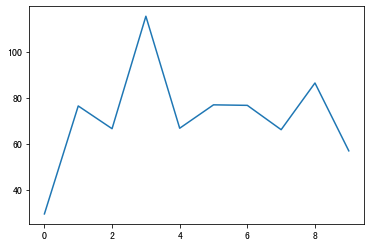

In [9]:
plt.plot(loss_record)
plt.show()

In [10]:
transform('i am good', encoder, decoder)

['总让', '紅肉', '製', '试', '反感', '經理', '老朋友', '環顧', '耗費', '指南']

# Teacher Forcing 模型训练

## 模型超参数定义

In [11]:
# 定义超参数
EPOCH = 3
LEARN_RATE = 0.001
word_embedding_dim = 128
gru_hidden_size = 64
gru_num_layers = 1

# 定义GPU设备
device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 创建encoder
encoder_words_num = len(en_to_word)
encoder = EncoderRNN(encoder_words_num, word_embedding_dim, gru_hidden_size, gru_num_layers).to(device) # word_num, embedding_dim

# 创建decoder
decoder_words_num = len(cn_to_word)
decoder_t = DecoderRNN(decoder_words_num, word_embedding_dim, gru_hidden_size, gru_num_layers, strategy='Teacher Forcing').to(device) # word_num, embedding_dim, strategy

# 定义优化器
parameters = list(encoder.parameters()) + list(decoder.parameters())
optimizer = optim.Adam(parameters, lr=LEARN_RATE)

# 定义损失函数
loss_fun = nn.NLLLoss()

## 模型训练

In [12]:
loss_record = []
for epoch in range(EPOCH):
    for i, j in zip(input_data, label_data):
        
        # 数据转换成tensor并放进GPU
        data_x = torch.LongTensor([i]).to(device)  # embedding input:(N, W), N_batch, W = 每个mini-batch中提取的下标数
        label_data_y = torch.LongTensor(j+[1]).to(device)  # 添加结束符号到最后一个，并转换成符合loss函数的数据维度（batch， class_idx）
        teacher_data_y = torch.LongTensor([0]+j).to(device)

        # 初始化损失值，清空梯度
        loss = 0
        optimizer.zero_grad()
        
        # encoder过程，获取最后一层隐向量C
        vector_c = encoder(data_x)
        
        # decoder过程
        output_softmax =  decoder_t(teacher_data_y, vector_c)
        
        # 反向传播，参数更新
        loss = loss_fun(output_softmax, label_data_y)
        loss.backward()
        optimizer.step()
    
        loss_record.append(loss.item())
        print(loss.item())
    

9.558117866516113
9.570271492004395
9.596956253051758
9.55525016784668
9.567291259765625
9.528020858764648
9.5988130569458
9.601279258728027
9.558696746826172
9.500125885009766
9.270623207092285
9.538405418395996
9.55985164642334
9.53418254852295
9.532029151916504
9.496129035949707
9.562631607055664
9.571344375610352
9.531841278076172
9.453112602233887
9.124052047729492
9.518655776977539
9.531651496887207
9.517216682434082
9.502301216125488
9.467632293701172
9.528735160827637
9.540809631347656
9.50303840637207
9.404248237609863


## loss曲线

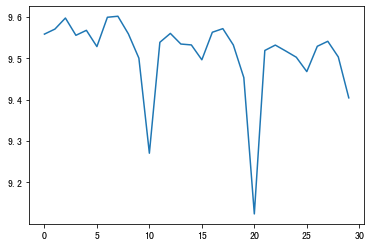

In [13]:
plt.plot(loss_record)
plt.show()

## Sample 执行

In [14]:
transform('i am good', encoder, decoder_t)

['海滩', '綻', '五', '会议室', '但是', '詢問', '沒氣', '獸醫', '吃太多', '筆嗎']